In [1]:
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import csv
import numpy as np
import torch
import torch.nn as nn

import datetime

import sys
import os

sys.path.append('../')


from envs.random_walk import RandomWalkEnv
# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.random_walk_dataset import RandomWalkDataset
from data.trajectory import LimitedContextWrapper
from settings import LOG_DIR
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

pygame 2.5.2 (SDL 2.28.2, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-05-08 07:14:37.035397: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 07:14:37.347442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 07:14:38.332484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device(type='cuda')

In [2]:
class Logger:
	def __init__(self, name):
		self.name = name
		self.start_time = datetime.datetime.now().replace(microsecond=0)
		self.best_score = -np.inf
		self.iters = 0
		self.num_updates_per_iter = 0
		self.previous_csv_extra_keys = None
		
		self.log_dir = os.path.join(LOG_DIR, "dt_runs")
		
		self.save_model_path = ""
		self.save_best_model_path = ""

		if not os.path.exists(self.log_dir):
			os.makedirs(self.log_dir)
		
		self.csv_writer = None
		self.pbar = None		
		self.is_started = False

	def start(self, iterations, update_per_iter):		
		self.start_time = datetime.datetime.now().replace(microsecond=0)
		self.best_score = -np.inf
		self.iters = 0
		self.num_updates_per_iter = update_per_iter
		self.previous_csv_extra_keys = None
		
		prefix = "dt_"
		start_time_str = self.start_time.strftime("%y-%m-%d-%H-%M-%S")
		save_model_name = prefix + self.name + "_model_" + start_time_str + ".pt"
		self.save_model_path = os.path.join(self.log_dir, save_model_name)
		self.save_best_model_path = self.save_model_path[:-3] + "_best.pt"
		log_csv_name = prefix + "_log_" + start_time_str + ".csv"
		log_csv_path = os.path.join(self.log_dir, log_csv_name)
		self.csv_writer = csv.writer(open(log_csv_path, 'a', 1))
		
		self.pbar = None		
		self.is_started = True
		self.pbar = tqdm(total=iterations)

	def finish(self):
		print("=" * 60)
		print("finished training!")
		print("=" * 60)
		end_time = datetime.datetime.now().replace(microsecond=0)
		time_elapsed = str(end_time - self.start_time)
		end_time_str = end_time.strftime("%y-%m-%d-%H-%M-%S")
		
		start_time_str = self.start_time.strftime("%y-%m-%d-%H-%M-%S")

		print("started training at: " + start_time_str)
		print("finished training at: " + end_time_str)
		print("total training time: " + time_elapsed)
		print("best score: " + format(self.best_score, ".5f"))
		print("saved max d4rl score model at: " + self.save_best_model_path)
		print("saved last updated model at: " + self.save_model_path)
		print("=" * 60)

		self.is_started = False
		self.csv_writer.close()

	# todo later make it generic so that we can log whatever
	def log(self, model, loss, eval_avg_reward, important=set(), **kwargs):		
		if not self.is_started:
			raise Exception("call .start() first")

		if self.previous_csv_extra_keys is None:
			self.previous_csv_extra_keys = list(kwargs.keys())
			csv_header = (["duration", "num_updates", "action_loss", "eval_avg_reward", "best_score", *kwargs.keys()])
			self.csv_writer.writerow(csv_header)
		elif set(self.previous_csv_extra_keys) != set(kwargs.keys()):
			raise Exception(f"expected {set(self.previous_csv_extra_keys)} keys but passed {set(kwargs.keys())}. Maybe call finish?")
		
		self.iters += 1
		time_elapsed = str(datetime.datetime.now().replace(microsecond=0) - self.start_time)
		total_updates = self.iters * self.num_updates_per_iter
				
		log_str = '\n'.join([
			"=" * 60,
			"time elapsed: " + time_elapsed,
			"num of updates: " + str(total_updates),
			"loss: " +  format(loss, ".5f"),
			"eval avg reward: " + format(eval_avg_reward, ".5f"),
			"best score: " + format(self.best_score, ".5f"),
			*[key + " " + format(value, ".5f") for key, value in kwargs.items()]
		])

		log_data = [time_elapsed, total_updates, loss,
					eval_avg_reward, self.best_score] + [kwargs[key] for key in self.previous_csv_extra_keys]
		self.csv_writer.writerow(log_data)
		if eval_avg_reward >= self.best_score:
			print('achieved average reward: ', eval_avg_reward)
			print("saving max score model at: " + self.save_best_model_path)

			torch.save(model.state_dict(), self.save_best_model_path)
			self.best_score = eval_avg_reward
	
		print("saving current model at: " + self.save_model_path)
		torch.save(model.state_dict(), self.save_model_path)
		

		self.pbar.set_description(' '.join([
			f'Loss={loss}',
			f'Best_Score={self.best_score}',
			*[f'{key}={value:.5f}' for key, value in kwargs.items() if key in important]
		]))
		
		self.pbar.update(1)
		
		print(log_str)

In [3]:
from typing import Tuple
from dataclasses import dataclass

@dataclass
class TrainConfig:
	max_eval_ep_len: int      # max len of one evaluation episode
	context_len: int         # K in decision transformer
	rtg_range_check: Tuple[float, float]
	rtg_main: float
	
	num_eval_ep: int = 10          # num of evaluation episodes per iteration	
	batch_size: int = 64             # training batch size
	lr: float = 1e-3                   # learning rate
	wt_decay: float = 1e-4             # weight decay
	warmup_steps: int = 10000        # warmup steps for lr scheduler
	
	# total updates = max_train_iters x num_updates_per_iter
	max_train_iters: int = 200
	num_updates_per_iter: int = 100

	# GPT config	
	n_blocks: int = 3            # num of transformer blocks
	embed_dim: int = 128         # embedding (hidden) dim of transformer
	n_heads: int = 1             # num of transformer heads
	dropout_p: float = 0.1         # dropout probability


def train(model, optimizer, loss_fn, traj_dataset, config: TrainConfig, callbacks=[]):
	
	dataset = LimitedContextWrapper(traj_dataset, context_len=config.context_len)
	traj_data_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
	data_iter = iter(traj_data_loader)
		
	logger.start(iterations=config.max_train_iters, update_per_iter=config.num_updates_per_iter)

	log_action_losses_all = []
	
	for i_train_iter in range(config.max_train_iters):
		log_action_losses = []
		model.train()
	 
		for _ in range(config.num_updates_per_iter):
			try:
				timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
			except StopIteration:
				data_iter = iter(traj_data_loader)
				timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
	
			timesteps = timesteps.to(device)	# B x T
			states = states.to(device)			# B x T x state_dim
			actions = actions.to(device)		# B x T x act_dim
			returns_to_go = returns_to_go.to(device).unsqueeze(dim=-1) # B x T x 1
			traj_mask = traj_mask.to(device)	# B x T
	
			action_target = torch.clone(actions).detach().to(device)
		
			state_preds, action_preds, return_preds = model.forward(
															timesteps=timesteps,
															states=states,
															actions=actions,
															returns_to_go=returns_to_go
														)
			# only consider non padded elements
			act_dim = action_preds.shape[-1]
			action_preds = action_preds.view(-1, act_dim)[traj_mask.view(-1,) > 0]
			action_target = action_target.view(-1, act_dim)[traj_mask.view(-1,) > 0]
	
			action_loss = loss_fn(action_preds, action_target)
	
			optimizer.zero_grad()
			action_loss.backward()
			torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
			optimizer.step()
			scheduler.step()
			
			log_action_losses.append(action_loss.detach().cpu().item())
			log_action_losses_all.append(log_action_losses[-1])
	
		for callback in callbacks:
			callback(loss=np.mean(log_action_losses))

	plt.plot(log_action_losses_all)
	plt.show()

In [25]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, loss, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=loss,
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_ep_len'] for res in self.eval_results[n//2:]])

Dataset Info:
episode_max_length: 20
reward_scale: 20
return min=-130, max=9 mean=-27.980613165013526
state_mean: [0.21235347 0.09467989 0.10144274 0.10302074 0.08724076 0.09918846
 0.09986474 0.09941389 0.10279531 0.        ]
state_std: [0.40897368 0.29277228 0.30191408 0.30398596 0.28218754 0.29891488
 0.29981957 0.29921692 0.30369135 0.        ]
gamma: 1


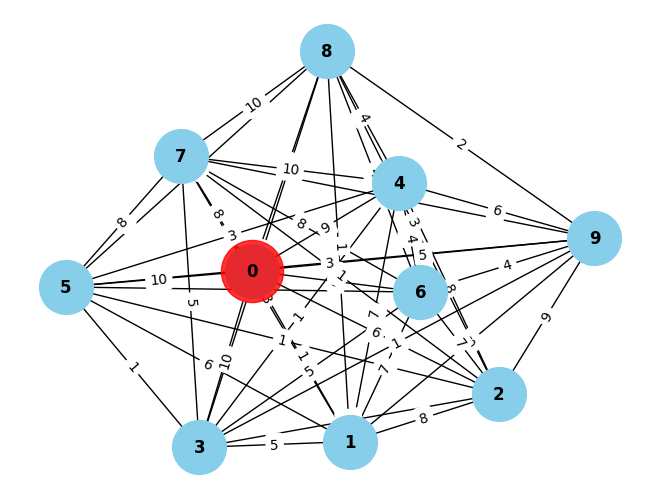

In [5]:
env = RandomWalkEnv(num_nodes=10, weight_max=10, reach_the_goal_reward=10, max_episode_length=20)
config = TrainConfig(max_eval_ep_len=20, context_len=25, rtg_range_check=(-10, 10), rtg_main=5)
traj_dataset = RandomWalkDataset(env, n_trajectories=500, reward_scale=20)

env.reset()
env.render()

number of parameters 1125141


  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -15.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-07-14-42_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-07-14-42.pt
time elapsed: 0:00:02
num of updates: 100
loss: 0.27819
eval avg reward: -15.00000
best score: -inf
eval_avg_ep_len 6.00000
grad_norm 0.18711
lr 0.00001
achieved average reward:  5.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-07-14-42_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-07-14-42.pt
time elapsed: 0:00:03
num of updates: 200
loss: 0.15009
eval avg reward: 5.00000
best score: -15.00000
eval_avg_ep_len 1.00000
grad_norm 0.12503
lr 0.00002
achieved average reward:  5.0
saving max score model at: /home/shayan/projects/

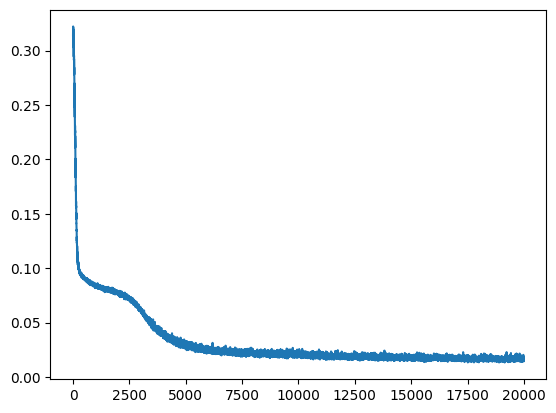

finished training!
started training at: 24-05-08-07-14-42
finished training at: 24-05-08-07-18-23
total training time: 0:03:41
best score: 6.00000
saved max d4rl score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-07-14-42_best.pt
saved last updated model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk_model_24-05-08-07-14-42.pt


AttributeError: '_csv.writer' object has no attribute 'close'

In [6]:
logger = Logger(name='random-walk')

model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

callback = CustomCallback(env=env, model=model, optimizer=optimizer, logger=logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

train(model=model, optimizer=optimizer,
	  loss_fn=nn.MSELoss(reduction='mean'),
	  traj_dataset=traj_dataset, config=config,
	  callbacks=[callback.callback])

logger.finish()

In [7]:
# env = RandomWalkEnv(verbose=True)
# 
# evaluate_on_env(
# 	model=model,
# 	traj_dataset=traj_dataset,
# 	device=device,
# 	context_len=context_len,
# 	env=env,
# 	rtg_target=rtg_target,
# 	num_eval_ep=num_eval_ep
# )

/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/extensions/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins.extensions')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/e

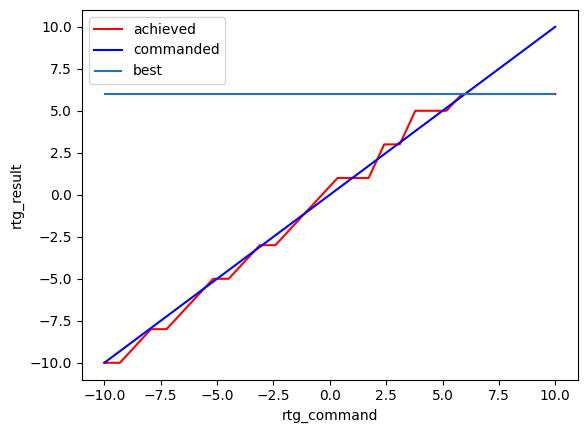

In [20]:
rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)

rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


import networkx as nx

shortest_path = nx.shortest_path(env.G, env.starting_vertex, env.ending_vertex, weight='weight')
best_score = env.reach_the_goal_reward - sum(env.G[a][b]['weight'] for a, b in zip(shortest_path[:-1], shortest_path[1:]))

plt.hlines(best_score, config.rtg_range_check[0], config.rtg_range_check[1])

plt.legend(["achieved", "commanded", "best"])


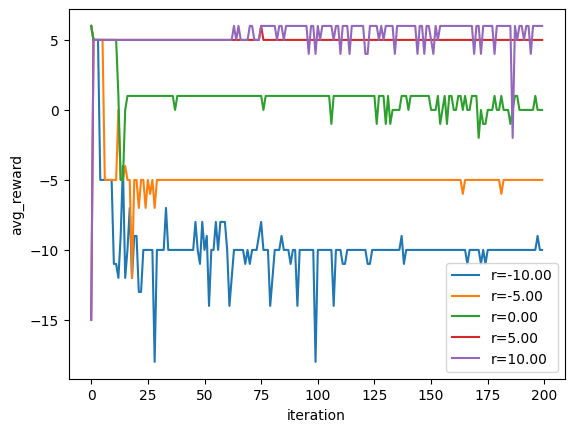

In [9]:
callback.plot_eval_results()

### Make it harder?

Dataset Info:
episode_max_length: 30
reward_scale: 200
return min=-5863, max=39 mean=-2161.9398490359417
state_mean: [0.04908287 0.00962103 0.00985568 0.0099339  0.01012945 0.01005123
 0.00966014 0.00977746 0.00946459 0.01005123 0.00938637 0.00958192
 0.01052055 0.01012945 0.01005123 0.00934726 0.00907349 0.00899527
 0.0099339  0.0095037  0.00966014 0.010325   0.01059877 0.00848684
 0.00985568 0.01059877 0.00962103 0.00934726 0.00958192 0.00969925
 0.00969925 0.00962103 0.01001212 0.01020767 0.00966014 0.00938637
 0.00848684 0.00891705 0.00930815 0.00883883 0.00942548 0.01036411
 0.00840862 0.01009034 0.00899527 0.00966014 0.01009034 0.01055966
 0.00946459 0.00966014 0.0099339  0.00973836 0.00860417 0.00997301
 0.01095076 0.00954281 0.01048144 0.01009034 0.0091126  0.010325
 0.0099339  0.00969925 0.00966014 0.00962103 0.00860417 0.00879972
 0.00942548 0.00962103 0.00946459 0.00954281 0.00907349 0.00899527
 0.00903438 0.00977746 0.00966014 0.01098987 0.0091126  0.0095037
 0.01036411 0.0

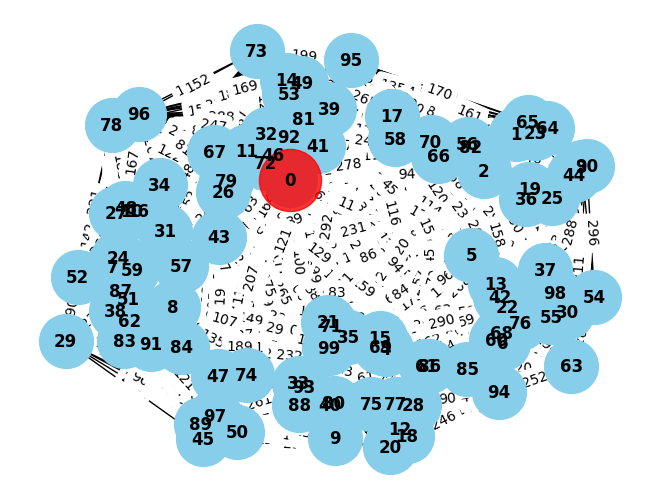

In [21]:
env = RandomWalkEnv(num_nodes=100, weight_max=300, reach_the_goal_reward=40, max_episode_length=30)
config = TrainConfig(max_eval_ep_len=30, context_len=32, rtg_range_check=(-50, 40), rtg_main=5)
traj_dataset = RandomWalkDataset(env, n_trajectories=1000, reward_scale=200)

env.reset()
env.render()

number of parameters 1171401


  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -4290.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-big_model_24-05-08-07-49-18_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-big_model_24-05-08-07-49-18.pt
time elapsed: 0:00:01
num of updates: 100
loss: 0.21419
eval avg reward: -4290.00000
best score: -inf
eval_avg_ep_len 30.00000
grad_norm 0.10034
lr 0.00001
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-big_model_24-05-08-07-49-18.pt
time elapsed: 0:00:04
num of updates: 200
loss: 0.13510
eval avg reward: -4535.00000
best score: -4290.00000
eval_avg_ep_len 30.00000
grad_norm 0.08736
lr 0.00002
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-big_model_24-05-08-07-49-18.pt
time elapsed: 0:00:07
num of updates: 300
loss: 0.03318
eval avg reward: -4393.00000
bes

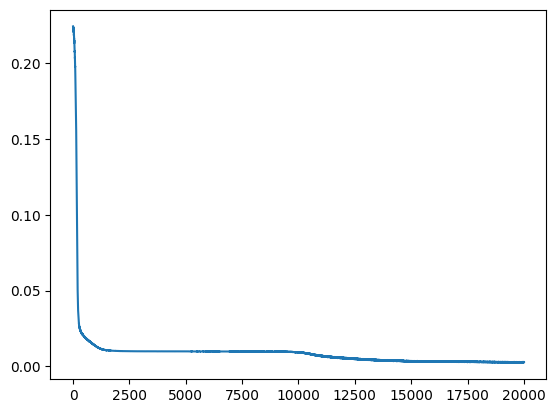

finished training!
started training at: 24-05-08-07-49-18
finished training at: 24-05-08-07-53-54
total training time: 0:04:36
best score: 6.00000
saved max d4rl score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-big_model_24-05-08-07-49-18_best.pt
saved last updated model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-big_model_24-05-08-07-49-18.pt


AttributeError: '_csv.writer' object has no attribute 'close'

In [26]:
logger = Logger(name='random-walk-big')

model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

callback = CustomCallback(env=env, model=model, optimizer=optimizer, logger=logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

train(model=model, optimizer=optimizer,
	  loss_fn=nn.MSELoss(reduction='mean'),
	  traj_dataset=traj_dataset, config=config,
	  callbacks=[callback.callback])

logger.finish()

[autoreload of algorithms.sequence_models.old_decision_transformer.decision_transformer.trainer failed: Traceback (most recent call last):
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/shayan/projects/RL-credit-assignment-experiment/algorithms/sequence_models/old_decision_transformer/decision_transformer/trainer.py", line 4, in <module

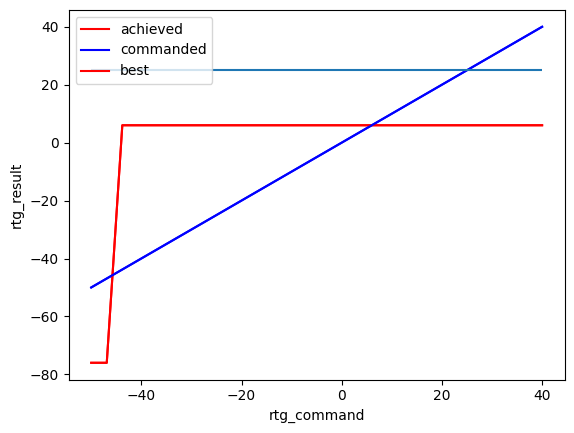

In [23]:
rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)

rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)

rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


import networkx as nx

shortest_path = nx.shortest_path(env.G, env.starting_vertex, env.ending_vertex, weight='weight')
best_score = env.reach_the_goal_reward - sum(env.G[a][b]['weight'] for a, b in zip(shortest_path[:-1], shortest_path[1:]))

plt.hlines(best_score, config.rtg_range_check[0], config.rtg_range_check[1])

plt.legend(["achieved", "commanded", "best"])


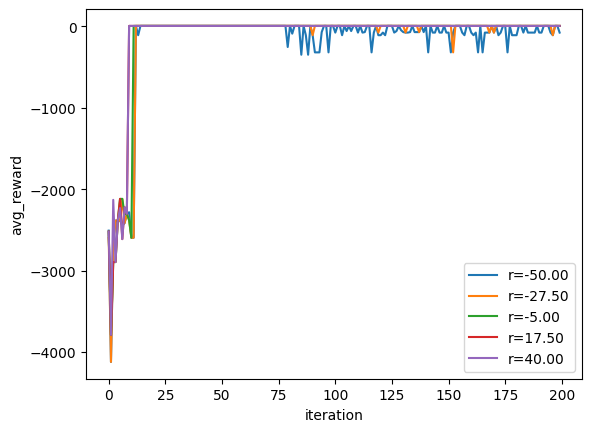

In [24]:
callback.plot_eval_results()